In [10]:
from tsfm import generator, ols_estimator, plot_preds

In [11]:
df = generator()
df.head()

,x,y
0,0.293260,1.956726
1,1.085273,2.090996
2,-1.440081,2.835432
3,-1.178073,1.811114
4,-0.015719,0.582980


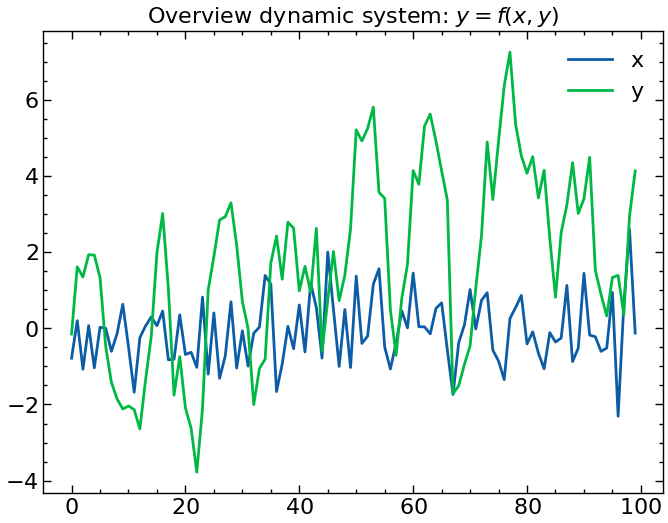

In [42]:
df.plot(title=r"Overview dynamic system: $y=f(x, y)$");

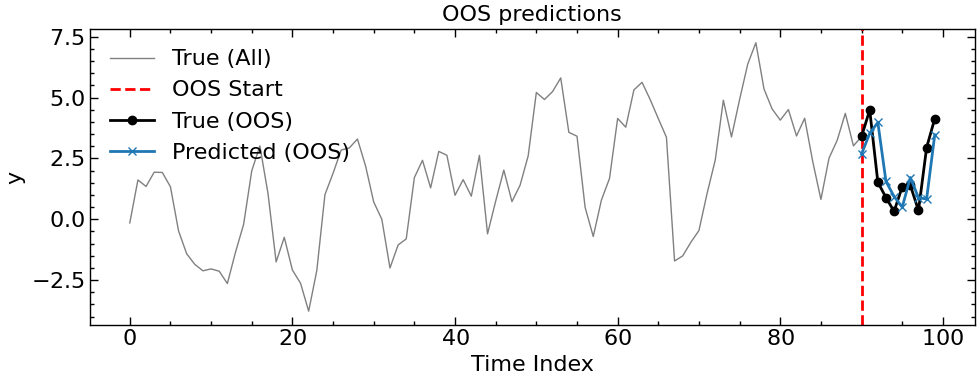

In [43]:
yhs = ols_estimator(df)
plot_preds(df, yhs)

In [ ]:
from tsfm.proxies import setup_huggingface

setup_huggingface()

In [ ]:
import numpy as np
import torch
from transformers import TimesFmModelForPrediction


def timesfm_oos_predict_hf(
    df,
    n_oos,
    context_len=512,
    model_id="google/timesfm-2.0-500m-pytorch",
    device="cuda" if torch.cuda.is_available() else "cpu",
):
    """
    Forecast the last `n_oos` points of a univariate series with TimesFM
    using the raw Transformers model.

    Args
    ----
    df : pd.DataFrame
        Must contain column 'y'.
    n_oos : int
        Horizon to forecast.
    context_len : int
        Max history length fed to the model (<= model config's context_length).
    model_id : str
        Hugging Face model repo.
    device : str
        "cuda" or "cpu".

    Returns
    -------
    np.ndarray
        Point forecasts of length `n_oos`.
    """
    # 1 · load model (weights are downloaded once and cached)
    model = TimesFmModelForPrediction.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        attn_implementation="sdpa",
        device_map=device,
    )

    model.eval()  # no dropout, etc.

    # 2 · prepare context (past values)  ────────────────────────────────
    past_values = df["y"].values[:-n_oos]
    past_values = past_values[-context_len:]  # clip to max context
    past_values = torch.tensor(
        past_values, dtype=torch.bfloat16, device=device
    ).unsqueeze(0)  # (1, T)

    # TimesFM also expects a frequency index per series; use 0 by default
    freq = torch.tensor([0], dtype=torch.long, device=device)  # (1,)

    # 3 · run model  ────────────────────────────────────────────────────
    with torch.no_grad():
        out = model(
            past_values=past_values,
            freq=freq,
            forecast_context_len=context_len,
            future_values=None,
            truncate_negative=False,
            return_dict=True,
        )

    y_pred = out.mean_predictions.float().cpu().numpy()[0]  # (n_oos,)

    return y_pred


timesfm_oos_predict_hf(df, n_oos=10)


c:\Mambaforge\envs\uv\projects\tsfm\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app-gw-2.ecb.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Mambaforge\envs\uv\projects\tsfm\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app-gw-2.ecb.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Mambaforge\envs\uv\projects\tsfm\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'app-gw-2.ecb.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

c:\Mambaforge\envs\uv\projects\tsfm\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aarabil\.cache\huggingface\hub\models--google--timesfm-2.0-500m-pytorch. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ValueError: Using a `device_map`, `tp_plan`, `torch.device` context manager or setting `torch.set_default_device(device)` requires `accelerate`. You can install it with `pip install accelerate`